In [12]:
import numpy as np
from collections import defaultdict
import string
import heapq
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pickle
import os
import regex as re

## Darija2Vec algorithm

In [44]:
class Darija2Vec:
    def __init__(self, corpus, emb_dim=100, window_size=5, learning_rate=0.025):
        self.corpus = corpus
        self.emb_dim = emb_dim
        self.window_size = window_size
        self.learning_rate = learning_rate
        self.vocab = list(set(self.corpus))
        self.word_to_index = {w: i for i, w in enumerate(self.vocab)}
        self.index_to_word = {i: w for i, w in enumerate(self.vocab)}
        self.vocab_size = len(self.vocab)
        self.W1 = np.random.uniform(-0.8, 0.8, (self.vocab_size, self.emb_dim))
        self.W2 = np.random.uniform(-0.8, 0.8, (self.emb_dim, self.vocab_size))

    def generate_training_data(self):
        training_data = []
        for i, word in enumerate(self.corpus):
            for j in range(max(0, i - self.window_size), i):
                training_data.append((word, self.corpus[j]))
            for j in range(i + 1, min(i + self.window_size + 1, len(self.corpus))):
                training_data.append((word, self.corpus[j]))
        return training_data

    def one_hot(self, index):
        one_hot_vec = np.zeros(self.vocab_size)
        one_hot_vec[index] = 1
        return one_hot_vec

    def train(self, epochs):
        training_data = self.generate_training_data()
        for epoch in range(epochs):
            self.loss = 0
            for w, c in training_data:
                x = self.one_hot(self.word_to_index[w])
                y = self.one_hot(self.word_to_index[c])
                h = np.dot(x, self.W1)
                u = np.dot(h, self.W2)
                y_pred = self.softmax(u)
                error = y - y_pred
                self.loss += np.sum(error ** 2)
                dW2 = np.outer(h, error)
                dW1 = np.outer(x, np.dot(self.W2, error))
                self.W2 += self.learning_rate * dW2
                self.W1 += self.learning_rate * dW1
            print("Epoch %d, loss: %.4f" % (epoch+1, self.loss))

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)

    def get_embedding(self, word):
        return self.W1[self.word_to_index[word]]
    
    def get_similar_words(self, word, n=5):
        if word not in self.vocab:
            return f"{word} not in vocabulary"
        
        word_emb = self.get_embedding(word)
        scores = {}
        for w in self.vocab:
            if w != word:
                emb = self.get_embedding(w)
                scores[w] = np.dot(word_emb, emb) / (np.linalg.norm(word_emb) * np.linalg.norm(emb))
        
        top_n = heapq.nlargest(n, scores, key=scores.get)
        return top_n

## Data : 

In [17]:
def clean_text(text):
    no_punct = text.translate(str.maketrans("", "", string.punctuation ))
    no_new_line = no_punct.replace("\n", " ")
    text_without_digits = re.sub(r'\b\d+\b', '', no_new_line)
    no_unicode =  re.sub(r'\\u[0-9a-fA-F]{4}', '', text_without_digits.encode('unicode-escape').decode())
    return no_unicode

def get_corpus(data_dir):
    corpus = ""
    for data_file in os.listdir(data_dir):
        with open(os.path.join(data_dir, data_file), "r", encoding="utf-8") as f:
            file_text = f.read()
            cleaned_text = clean_text(file_text)
            corpus += cleaned_text
    return corpus 

In [51]:
corpus = get_corpus('data/')

In [41]:
num_tokens = pd.Series(corpus.split()).nunique()
print(f"Number of tokens : {num_tokens}")

Number of tokens : 2230


In [59]:
model = Darija2Vec(corpus.split(), emb_dim=10, window_size=4, learning_rate=0.01)

In [119]:
model.learning_rate = 0.001
model.train(epochs=200)

Epoch 1, loss: 37705.2664
Epoch 2, loss: 37602.1473
Epoch 3, loss: 37570.3590
Epoch 4, loss: 37552.4062
Epoch 5, loss: 37540.4237
Epoch 6, loss: 37531.6855
Epoch 7, loss: 37524.9560
Epoch 8, loss: 37519.5757
Epoch 9, loss: 37515.1524
Epoch 10, loss: 37511.4354
Epoch 11, loss: 37508.2564
Epoch 12, loss: 37505.4978
Epoch 13, loss: 37503.0748
Epoch 14, loss: 37500.9245
Epoch 15, loss: 37498.9995
Epoch 16, loss: 37497.2630
Epoch 17, loss: 37495.6859
Epoch 18, loss: 37494.2451
Epoch 19, loss: 37492.9218
Epoch 20, loss: 37491.7006
Epoch 21, loss: 37490.5686
Epoch 22, loss: 37489.5153
Epoch 23, loss: 37488.5315
Epoch 24, loss: 37487.6096
Epoch 25, loss: 37486.7429
Epoch 26, loss: 37485.9258
Epoch 27, loss: 37485.1533
Epoch 28, loss: 37484.4212
Epoch 29, loss: 37483.7256
Epoch 30, loss: 37483.0634
Epoch 31, loss: 37482.4315
Epoch 32, loss: 37481.8274
Epoch 33, loss: 37481.2488
Epoch 34, loss: 37480.6937
Epoch 35, loss: 37480.1601
Epoch 36, loss: 37479.6466
Epoch 37, loss: 37479.1515
Epoch 38, 

In [123]:
model.get_similar_words("rassi")

['farid', 'forever', 'Hrasst', 'l9a', 'derbi']

## Vizualization using PCA

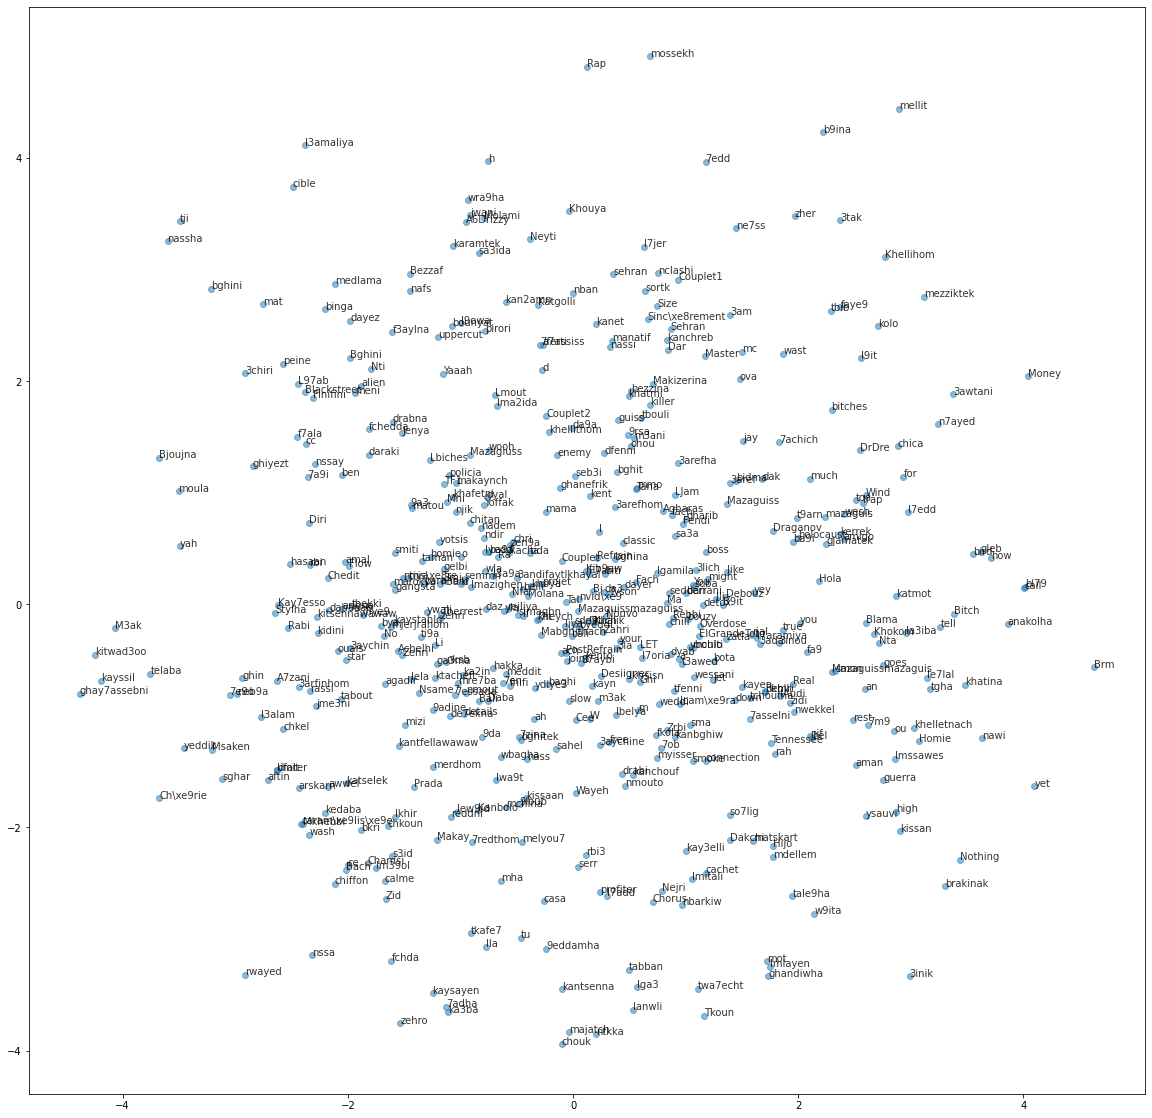

In [124]:
# Get the word vectors for a subset of the vocabulary
word_vectors = np.array([model.get_embedding(w) for w in model.vocab[:500]])

# Apply PCA to reduce the dimensionality of the word vectors
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)
plt.figure(figsize = (20,20))

# Plot the word vectors in 2D space
plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1], alpha=0.5)

# Label each point with its corresponding word
for i, word in enumerate(model.vocab[:500]):
    plt.annotate(word, xy=(word_vectors_pca[i, 0], word_vectors_pca[i, 1]), alpha=0.8)

plt.show()


## Playing with clusters 

Cluster  1 :  ['smon', 'ikhsisn', 'arigna', 'so7lig', 'down', 'ghin', 'aftin', 'fchda', 'arskarn', 'yotsis', 'rbi', 'lwa9t', 'Yoffak', 'agadir', 'matskart', 'Bi', '3mi', 'ghayan', 'Aybzg', 'bouhssine', 'Ayaj', '7asbka', 'Sit', 'rayi', 'here', 'nique', 'fjnbi', 'wl7adir', 'right', 'it', 'ossanek', 'rachi', 'Ordark', 'Lbarlamane', 'Ghin', 'Yat', 'dow', 'tayan', 'Sma9el', 'A', 'Like', 'his', 'l7chich', 'Dex', 'flas', 'Wash', 'now', 'Ki', 'orzdin', 'Mills', 'zahri', 's', 'Reggie', 'lgdamenk', 'zod', 'ihor', 'tkmiy', 'aka', 'ogayonk', 'ord', 'Yolka', 'ghanl9ak', 'I9aridden', 'ayn']
Cluster  2 :  ['your', 'anakolha', '3lich', 't3awed', '7asselni', 'da3', 'bl79', 'nwekkel', 'detox', 'le7lal', 'Tkoun', 'bouzy', 'nkhlli', 'kissan', 'Rebbi', 'nawi', 'amigo', 'tale9ha', 'l7aramiya', 'rejliya', 'fkola', 'zidi', 'nif', 'hakka', 'Therrest', 'ou', 'call', 'connection', 'Homie', 'bota', 'code', '9achla', 'derbek', 'face', 'flista', 'Enywayz', 'baghich', 'mimi', 'wbghawni', 'baby', 'lfo9', '7ess', 'Kat

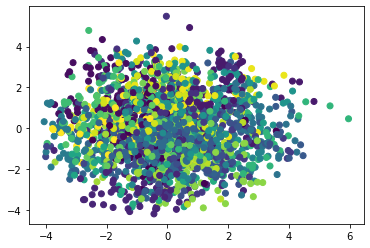

In [125]:
# Get the word embeddings from the model
word_embeddings = model.W1

# Use PCA to reduce the dimensionality of the embeddings to 2D for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(word_embeddings)

# Define the number of clusters
num_clusters = 30

# Use K-Means clustering to cluster the embeddings
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(word_embeddings)

# Get the cluster assignments for each word
cluster_assignments = kmeans.labels_

# Print the words in each cluster
for i in range(num_clusters):
    cluster_words = [word for j, word in enumerate(model.vocab) if cluster_assignments[j] == i]
    print("Cluster ", i+1, ": ", cluster_words)

# Visualize the clusters in 2D space
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_assignments)
plt.show()

In [129]:
with open('darija2vec.pkl', 'wb') as f:
    pickle.dump(model, f)

## get_similar_words

In [128]:
model.get_similar_words("rajel")

['nmed', '3emri', 'nkon', 'makarib', 'blaka']

In [127]:
model.get_similar_words("wash")

['lm39ol', 'so9', 'mok', 'Dirini', 'details']